In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! echo $PYTHONPATH

/env/python


In [3]:
import os
os.environ['PYTHONPATH'] += ":/content/drive/My Drive/Colab Notebooks/time-serie forecasting/"
! echo $PYTHONPATH

/env/python:/content/drive/My Drive/Colab Notebooks/time-serie forecasting/


**Import Libraries**

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import datetime
from datetime import date
import random

import warnings
warnings.filterwarnings('ignore')

**Import Data**

In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/time-serie forecasting/Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)

In [6]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [0]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')

In [0]:
data = data.set_index(pd.DatetimeIndex(data['date_time']))

In [0]:
ts = data['2018-03-30':'2018-09-29']

In [10]:
ts.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
date_time,,,,,,,,,
2018-03-30 00:00:00,None,272.30,0.0,0.0,1,Clear,sky is clear,2018-03-30 00:00:00,817
2018-03-30 01:00:00,None,271.93,0.0,0.0,1,Clear,sky is clear,2018-03-30 01:00:00,413
2018-03-30 02:00:00,None,271.22,0.0,0.0,1,Clear,sky is clear,2018-03-30 02:00:00,329
2018-03-30 03:00:00,None,270.09,0.0,0.0,1,Clear,sky is clear,2018-03-30 03:00:00,359
2018-03-30 04:00:00,None,269.65,0.0,0.0,1,Clear,sky is clear,2018-03-30 04:00:00,749


Train/Test Split

In [0]:
#Credit: Adopted from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [0]:
values = pd.DataFrame(ts.traffic_volume.values).set_index(pd.DatetimeIndex(ts['date_time']))

In [0]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = pd.DataFrame(scaler.fit_transform(values)).set_index(pd.DatetimeIndex(ts['date_time']))
# frame as supervised learning
reframed = series_to_supervised(scaled, 24, 1)

In [63]:
reframed.head()

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
date_time,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-30 23:00:00,0.094308,0.037100,0.025205,0.029453,0.084679,0.313792,0.610592,0.750212,0.718777,0.681535,0.671340,0.736194,0.797508,0.770037,0.787596,0.819173,0.819173,0.847635,0.727556,0.626168,0.488955,0.436420,0.406825,0.312518,0.217219
2018-03-31 00:00:00,0.037100,0.025205,0.029453,0.084679,0.313792,0.610592,0.750212,0.718777,0.681535,0.671340,0.736194,0.797508,0.770037,0.787596,0.819173,0.819173,0.847635,0.727556,0.626168,0.488955,0.436420,0.406825,0.312518,0.217219,0.114982
2018-03-31 00:00:00,0.025205,0.029453,0.084679,0.313792,0.610592,0.750212,0.718777,0.681535,0.671340,0.736194,0.797508,0.770037,0.787596,0.819173,0.819173,0.847635,0.727556,0.626168,0.488955,0.436420,0.406825,0.312518,0.217219,0.114982,0.114982
2018-03-31 01:00:00,0.029453,0.084679,0.313792,0.610592,0.750212,0.718777,0.681535,0.671340,0.736194,0.797508,0.770037,0.787596,0.819173,0.819173,0.847635,0.727556,0.626168,0.488955,0.436420,0.406825,0.312518,0.217219,0.114982,0.114982,0.060748
2018-03-31 01:00:00,0.084679,0.313792,0.610592,0.750212,0.718777,0.681535,0.671340,0.736194,0.797508,0.770037,0.787596,0.819173,0.819173,0.847635,0.727556,0.626168,0.488955,0.436420,0.406825,0.312518,0.217219,0.114982,0.114982,0.060748,0.060748


**Train test Split**

In [0]:
split_date = '2018-08-30'
ts_train = reframed.loc[reframed.index <= split_date].copy()
ts_test = reframed.loc[reframed.index > split_date].copy()

In [65]:
train_values = ts_train.values
test_values = ts_test.values
# split into input and outputs
train_X, train_y = train_values[:, :-1], train_values[:, -1]
test_X, test_y = test_values[:, :-1], test_values[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(4438, 1, 24) (4438,) (968, 1, 24) (968,)


# LSTM

In [0]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [0]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

## Vanilla LSTM

In [78]:
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit lstm
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(test_X, test_y), verbose=1, shuffle=False, callbacks=[es])

Train on 4438 samples, validate on 968 samples
Epoch 1/100
4438/4438 [==============================] - 5s 1ms/step - loss: 0.0746 - val_loss: 0.0311
Epoch 2/100
4438/4438 [==============================] - 1s 134us/step - loss: 0.0268 - val_loss: 0.0203
Epoch 3/100
4438/4438 [==============================] - 1s 128us/step - loss: 0.0200 - val_loss: 0.0157
Epoch 4/100
4438/4438 [==============================] - 1s 132us/step - loss: 0.0167 - val_loss: 0.0133
Epoch 5/100
4438/4438 [==============================] - 1s 128us/step - loss: 0.0143 - val_loss: 0.0113
Epoch 6/100
4438/4438 [==============================] - 1s 141us/step - loss: 0.0128 - val_loss: 0.0100
Epoch 7/100
4438/4438 [==============================] - 1s 137us/step - loss: 0.0117 - val_loss: 0.0092
Epoch 8/100
4438/4438 [==============================] - 1s 141us/step - loss: 0.0106 - val_loss: 0.0085
Epoch 9/100
4438/4438 [==============================] - 1s 137us/step - loss: 0.0101 - val_loss: 0.0080
Epoch 10/1

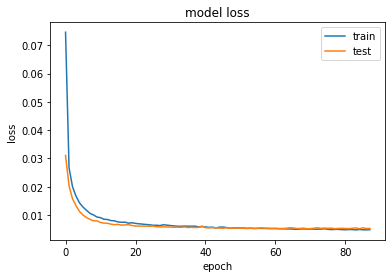

In [79]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
ts_train_fcst = model.predict(train_X)
ts_test_fcst = model.predict(test_X)
# invert predictions
ts_train_fcst = scaler.inverse_transform(ts_train_fcst)
train_y_i = scaler.inverse_transform([train_y])
ts_test_fcst = scaler.inverse_transform(ts_test_fcst)
test_y_i = scaler.inverse_transform([test_y])

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [86]:
print('Train Mean Absolute Error:', mean_absolute_error(train_y_i[0], ts_train_fcst[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y_i[0], ts_train_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(train_y_i[0], ts_train_fcst[:,0]))
print('Test Mean Absolute Error:', mean_absolute_error(test_y_i[0], ts_test_fcst[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y_i[0], ts_test_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(test_y_i[0], ts_test_fcst[:,0]))

Train Mean Absolute Error: 335.7626508499599
Train Root Mean Squared Error: 466.0101802844492
Test Mean Absolute percentage Error: 19.624351994073777
Test Mean Absolute Error: 364.4732391262843
Test Root Mean Squared Error: 513.8242004458365
Test Mean Absolute percentage Error: 22.254339962746677


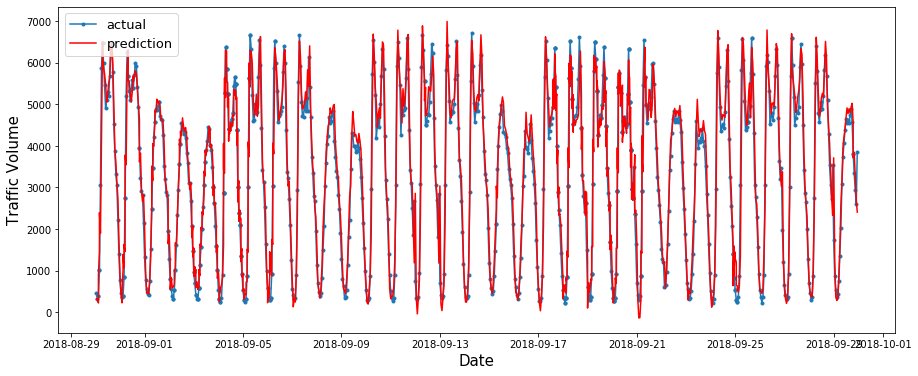

In [87]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(test_y_i[0]), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(ts_test_fcst[:,0]), 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

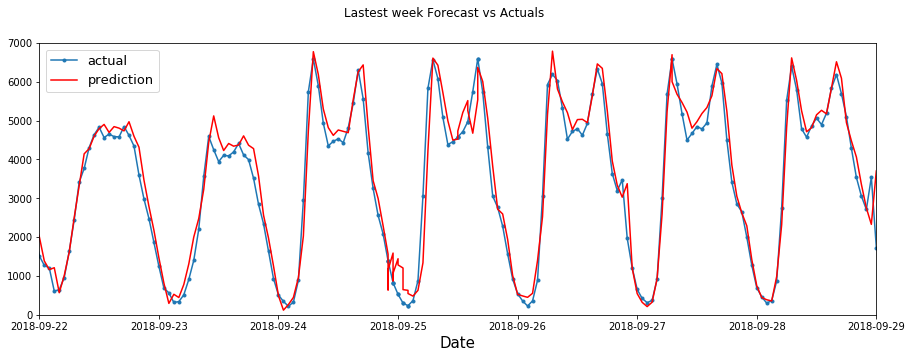

In [88]:
# zoom on lastest week)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(test_y_i[0]), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(ts_test_fcst[:,0]), 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 7000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

## Stacked LSTM

In [89]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit LSTM
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(test_X, test_y), verbose=1, shuffle=False, callbacks=[es])

Train on 4438 samples, validate on 968 samples
Epoch 1/100
4438/4438 [==============================] - 6s 1ms/step - loss: 0.0893 - val_loss: 0.0308
Epoch 2/100
4438/4438 [==============================] - 1s 211us/step - loss: 0.0275 - val_loss: 0.0192
Epoch 3/100
4438/4438 [==============================] - 1s 205us/step - loss: 0.0200 - val_loss: 0.0144
Epoch 4/100
4438/4438 [==============================] - 1s 208us/step - loss: 0.0164 - val_loss: 0.0115
Epoch 5/100
4438/4438 [==============================] - 1s 214us/step - loss: 0.0140 - val_loss: 0.0094
Epoch 6/100
4438/4438 [==============================] - 1s 229us/step - loss: 0.0124 - val_loss: 0.0082
Epoch 7/100
4438/4438 [==============================] - 1s 212us/step - loss: 0.0114 - val_loss: 0.0075
Epoch 8/100
4438/4438 [==============================] - 1s 208us/step - loss: 0.0103 - val_loss: 0.0070
Epoch 9/100
4438/4438 [==============================] - 1s 206us/step - loss: 0.0097 - val_loss: 0.0067
Epoch 10/1

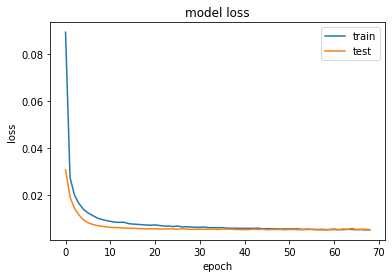

In [90]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
ts_train_fcst = model.predict(train_X)
ts_test_fcst = model.predict(test_X)
# invert predictions
ts_train_fcst = scaler.inverse_transform(ts_train_fcst)
train_y_i = scaler.inverse_transform([train_y])
ts_test_fcst = scaler.inverse_transform(ts_test_fcst)
test_y_i = scaler.inverse_transform([test_y])

In [92]:
print('Train Mean Absolute Error:', mean_absolute_error(train_y_i[0], ts_train_fcst[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y_i[0], ts_train_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(train_y_i[0], ts_train_fcst[:,0]))
print('Test Mean Absolute Error:', mean_absolute_error(test_y_i[0], ts_test_fcst[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y_i[0], ts_test_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(test_y_i[0], ts_test_fcst[:,0]))

Train Mean Absolute Error: 331.12612623822423
Train Root Mean Squared Error: 460.4774887054184
Test Mean Absolute percentage Error: 19.082845369848105
Test Mean Absolute Error: 364.4669128429791
Test Root Mean Squared Error: 513.8660917102951
Test Mean Absolute percentage Error: 21.941488704873148


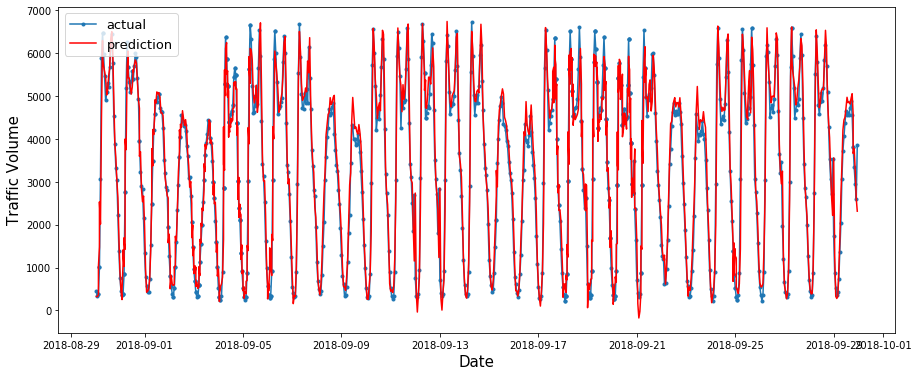

In [93]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(test_y_i[0]), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(ts_test_fcst[:,0]), 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

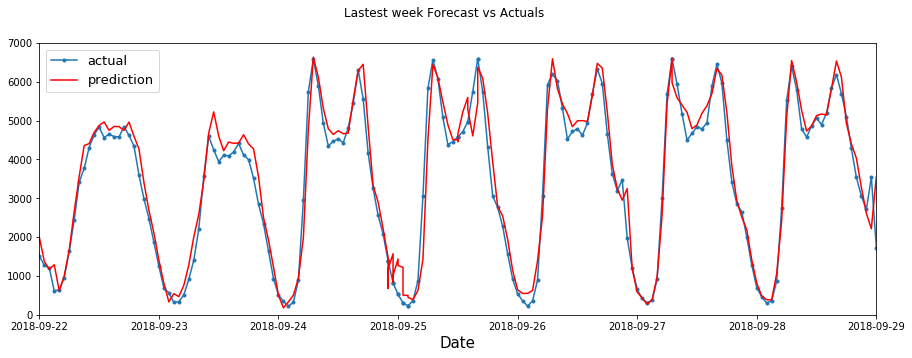

In [94]:
# zoom on lastest week)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(test_y_i[0]), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(ts_test_fcst[:,0]), 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 7000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

## Bidirectional LSTM 

In [95]:
model = Sequential()
model.add(Bidirectional(LSTM(64,activation='relu',), input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit LSTM
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(test_X, test_y), verbose=1, shuffle=False, callbacks=[es])

Train on 4438 samples, validate on 968 samples
Epoch 1/100
4438/4438 [==============================] - 7s 2ms/step - loss: 0.0654 - val_loss: 0.0240
Epoch 2/100
4438/4438 [==============================] - 1s 207us/step - loss: 0.0210 - val_loss: 0.0152
Epoch 3/100
4438/4438 [==============================] - 1s 239us/step - loss: 0.0154 - val_loss: 0.0122
Epoch 4/100
4438/4438 [==============================] - 1s 232us/step - loss: 0.0129 - val_loss: 0.0104
Epoch 5/100
4438/4438 [==============================] - 1s 211us/step - loss: 0.0110 - val_loss: 0.0091
Epoch 6/100
4438/4438 [==============================] - 1s 215us/step - loss: 0.0097 - val_loss: 0.0076
Epoch 7/100
4438/4438 [==============================] - 1s 216us/step - loss: 0.0089 - val_loss: 0.0076
Epoch 8/100
4438/4438 [==============================] - 1s 215us/step - loss: 0.0082 - val_loss: 0.0074
Epoch 9/100
4438/4438 [==============================] - 1s 214us/step - loss: 0.0077 - val_loss: 0.0070
Epoch 10/1

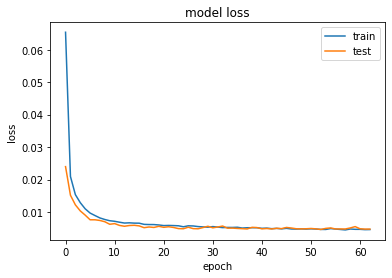

In [96]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
ts_train_fcst = model.predict(train_X)
ts_test_fcst = model.predict(test_X)
# invert predictions
ts_train_fcst = scaler.inverse_transform(ts_train_fcst)
train_y_i = scaler.inverse_transform([train_y])
ts_test_fcst = scaler.inverse_transform(ts_test_fcst)
test_y_i = scaler.inverse_transform([test_y])

In [98]:
print('Train Mean Absolute Error:', mean_absolute_error(train_y_i[0], ts_train_fcst[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y_i[0], ts_train_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(train_y_i[0], ts_train_fcst[:,0]))
print('Test Mean Absolute Error:', mean_absolute_error(test_y_i[0], ts_test_fcst[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y_i[0], ts_test_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(test_y_i[0], ts_test_fcst[:,0]))

Train Mean Absolute Error: 311.3892483154682
Train Root Mean Squared Error: 438.07519000035995
Test Mean Absolute percentage Error: 17.966212269002757
Test Mean Absolute Error: 343.455291905679
Test Root Mean Squared Error: 488.19913372588593
Test Mean Absolute percentage Error: 20.437379503219645


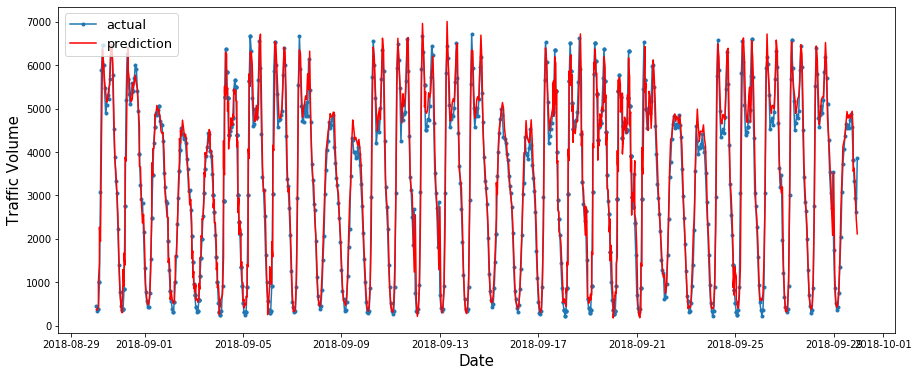

In [99]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(test_y_i[0]), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(ts_test_fcst[:,0]), 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

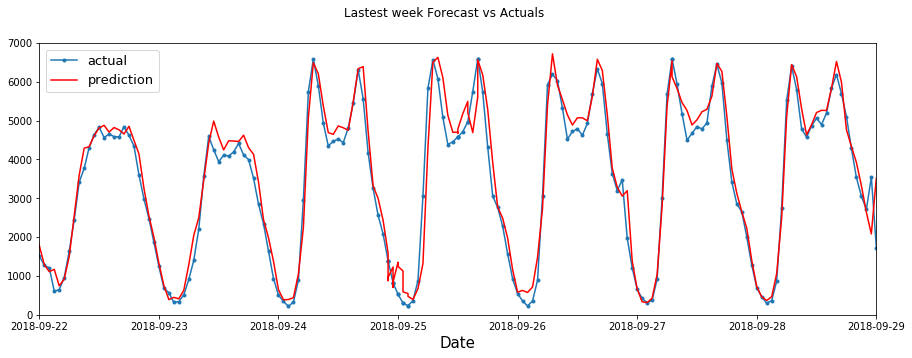

In [100]:
# zoom on lastest week)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(test_y_i[0]), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(ts_test_fcst[:,0]), 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 7000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')